# Problema de Negócio:

* Uma empresa de energia solar quer entender o impacto das condições meteorológicas na geração de energia solar. O objetivo é desenvolver um modelo que possa prever a Irradiância Global Horizontal (GHI) com base na umidade relativa do ar e na temperatura ambiente. Isso ajudará a empresa a otimizar a eficiência dos painéis solares em diferentes condições climáticas.

# Descrição das variáveis:

* TS: Timestamp (data e hora da medição).
* RH: Umidade relativa do ar (%).
* TAMB: Temperatura ambiente (°C).
* GHI: Irradiância global horizontal (W/m²).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
from sklearn.linear_model import LinearRegression

* Tratamento inicial dos dados:

In [2]:
# Carregando o arquivo:
df = pd.read_csv('weather_data.csv')

# Transformando a coluna 'TS' no formato datetime:
df['TS'] = pd.to_datetime(df['TS'])

# Criando uma variável para os registros mensais:
df_mensal = df.copy()
df_mensal.set_index('TS', inplace=True)
df_mensal = df_mensal.resample('M').mean()

# Criando uma variável para os registros diarios:
df_diario = df.copy()
df_diario.set_index('TS', inplace=True)
df_diario = df_diario.resample('D').mean()

# Colocando a variável 'TS' como indice do nosso dataframe:
df.set_index('TS', inplace=True)

df

/tmp/ipykernel_5048/392261222.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensal = df_mensal.resample('M').mean()


,RH,TAMB,GHI
TS,,,
2024-04-10 00:00:00,95.199997,24.900000,-1.0
2024-04-10 00:01:00,95.000000,24.900000,-1.0
2024-04-10 00:02:00,95.000000,24.900000,-0.5
2024-04-10 00:03:00,95.099998,24.900000,-0.5
2024-04-10 00:04:00,95.500000,24.900000,-0.5
...,...,...,...
2024-10-14 21:21:00,85.900002,23.799999,-0.5
2024-10-14 21:22:00,85.900002,23.799999,-0.5
2024-10-14 21:23:00,86.099998,23.799999,-0.5


In [3]:
df_mensal

,RH,TAMB,GHI
TS,,,
2024-04-30,89.434531,26.138483,172.665590
2024-05-31,87.293172,26.499536,191.091011
2024-06-30,84.662574,26.018147,221.243582
2024-07-31,73.553466,22.438278,196.695653
2024-08-31,71.869000,26.003777,262.255236
2024-09-30,67.606602,26.906787,275.334120
2024-10-31,70.799100,26.998220,272.110622


In [4]:
df_diario

,RH,TAMB,GHI
TS,,,
2024-04-10,89.567144,26.355476,159.156764
2024-04-11,89.512089,26.349825,163.468903
2024-04-12,88.047847,26.706389,240.848264
2024-04-13,90.931579,26.293985,178.477026
2024-04-14,NaN,NaN,NaN
...,...,...,...
2024-10-10,76.231111,26.422014,266.469792
2024-10-11,67.418403,27.432917,296.277778
2024-10-12,66.448472,27.654097,263.389931


In [5]:
# Substituindo os valores NaN do df_diario:
df_diario = df_diario.apply(lambda col: col.fillna(col.mean()), axis=0)

In [6]:
df_diario

,RH,TAMB,GHI
TS,,,
2024-04-10,89.567144,26.355476,159.156764
2024-04-11,89.512089,26.349825,163.468903
2024-04-12,88.047847,26.706389,240.848264
2024-04-13,90.931579,26.293985,178.477026
2024-04-14,76.434039,25.586265,230.307977
...,...,...,...
2024-10-10,76.231111,26.422014,266.469792
2024-10-11,67.418403,27.432917,296.277778
2024-10-12,66.448472,27.654097,263.389931


* Vamos verificar os tipos de dados e se há valores ausentes:

In [7]:
df_mensal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7 entries, 2024-04-30 to 2024-10-31
Freq: ME
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RH      7 non-null      float64
 1   TAMB    7 non-null      float64
 2   GHI     7 non-null      float64
dtypes: float64(3)
memory usage: 224.0 bytes


* Vamos fazer uma descrição do dataframe:

In [8]:
df.describe()

,RH,TAMB,GHI
count,224783.000000,224783.000000,224783.000000
mean,76.238337,25.679468,233.720984
std,18.038884,4.793512,331.019706
min,30.900000,2.200000,-20.000000
25%,62.599998,23.299999,-0.500000
50%,80.199997,25.100000,0.500000
75%,93.000000,29.200001,432.500000
max,499.899994,465.100006,1417.500000


* Podemos perceber que algumas variáves apresentam inconsistência: 
    1. A variável RH deveria ir de 0% a 100%, entretanto, podemos perceber que seu valor máximo é de quase 500%.
    2. A temperatura ambiente para o nordeste está beirando valores improvaveis para tal região.

* Vamos fazer um tratamento de outliers para as variáveis: RH e TAMB:

In [9]:
# Sabemos que os limites da umidade relativa é de 0% a 100%: 
limite_inferior_RH = 0
limite_superior_RH = 100

outliers_RH = (df['RH'] < limite_inferior_RH) | (df['RH'] > limite_superior_RH)

In [10]:
# Agora vamos tratar os outliers da temperatura ambiente. 
# O aceitável é uma temperatura ambiente entre 20°C e um pouco mais de 30°C.
IQR_TAMB = df['TAMB'].quantile(0.75) - df['TAMB'].quantile(0.25)
limite_inferior_TAMB = df['TAMB'].quantile(0.05) # 95% dos dados estão acima desse quartil 
limite_superior_TAMB = df['TAMB'].quantile(0.75) + (1.5 * IQR_TAMB)
outliers_TAMB = (df['TAMB'] <= limite_inferior_TAMB) | (df['TAMB'] >= limite_superior_TAMB)
limite_inferior_TAMB, limite_superior_TAMB

(20.700000762939453, 38.05000305175781)

In [11]:
# Dataframe flitrado:
outliers = (outliers_RH | outliers_TAMB)
df_limpo = df[~outliers]
df_limpo

,RH,TAMB,GHI
TS,,,
2024-04-10 00:00:00,95.199997,24.900000,-1.0
2024-04-10 00:01:00,95.000000,24.900000,-1.0
2024-04-10 00:02:00,95.000000,24.900000,-0.5
2024-04-10 00:03:00,95.099998,24.900000,-0.5
2024-04-10 00:04:00,95.500000,24.900000,-0.5
...,...,...,...
2024-10-14 21:21:00,85.900002,23.799999,-0.5
2024-10-14 21:22:00,85.900002,23.799999,-0.5
2024-10-14 21:23:00,86.099998,23.799999,-0.5


In [12]:
df_limpo.describe()

,RH,TAMB,GHI
count,213309.000000,213309.000000,213309.000000
mean,76.403615,26.356508,246.240902
std,17.955829,3.400170,335.254445
min,30.900000,20.799999,-20.000000
25%,62.700001,23.700001,-0.500000
50%,80.400002,25.299999,7.500000
75%,92.900002,29.299999,462.000000
max,99.599998,34.700001,1417.500000


* Agora que o DataFrame central já foi tratado, podemos apenas copiar e agrupar os dados médios mensais e diarios.

In [13]:
df_mensal = df_limpo.copy()
df_mensal = df_mensal.resample('M').mean()
df_mensal

/tmp/ipykernel_5048/2836804745.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensal = df_mensal.resample('M').mean()


,RH,TAMB,GHI
TS,,,
2024-04-30,89.434531,26.138483,172.665590
2024-05-31,87.293172,26.499536,191.091011
2024-06-30,84.662574,26.018147,221.243582
2024-07-31,75.484889,25.743579,253.636212
2024-08-31,70.833537,26.247805,273.469254
2024-09-30,67.183554,27.012960,279.689286
2024-10-31,70.799100,26.998220,272.110622


In [14]:
df_mensal.describe()

,RH,TAMB,GHI
count,7.000000,7.000000,7.000000
mean,77.955908,26.379819,237.700794
std,9.018687,0.484579,43.114730
min,67.183554,25.743579,172.665590
25%,70.816318,26.078315,206.167296
50%,75.484889,26.247805,253.636212
75%,85.977873,26.748878,272.789938
max,89.434531,27.012960,279.689286


In [15]:
df_diario = df_limpo.copy()
df_diario = df_diario.resample('D').mean()
df_diario

,RH,TAMB,GHI
TS,,,
2024-04-10,89.567144,26.355476,159.156764
2024-04-11,89.512089,26.349825,163.468903
2024-04-12,88.047847,26.706389,240.848264
2024-04-13,90.931579,26.293985,178.477026
2024-04-14,NaN,NaN,NaN
...,...,...,...
2024-10-10,76.231111,26.422014,266.469792
2024-10-11,67.418403,27.432917,296.277778
2024-10-12,66.448472,27.654097,263.389931


In [16]:
# Substituindo os valores NaN do df_diario:
df_diario = df_diario.apply(lambda col: col.fillna(col.mean()), axis=0)

In [17]:
df_diario

,RH,TAMB,GHI
TS,,,
2024-04-10,89.567144,26.355476,159.156764
2024-04-11,89.512089,26.349825,163.468903
2024-04-12,88.047847,26.706389,240.848264
2024-04-13,90.931579,26.293985,178.477026
2024-04-14,76.634982,26.310754,243.072086
...,...,...,...
2024-10-10,76.231111,26.422014,266.469792
2024-10-11,67.418403,27.432917,296.277778
2024-10-12,66.448472,27.654097,263.389931


In [18]:
df_diario.describe()

,RH,TAMB,GHI
count,188.000000,188.000000,188.000000
mean,76.634982,26.310754,243.072086
std,8.070126,0.734030,56.006177
min,60.088681,21.806250,0.000000
25%,69.702355,25.970035,234.466458
50%,76.634982,26.310754,243.603799
75%,83.363281,26.781809,276.987462
max,98.375260,27.837430,351.799734


# Vamos visualizar a distribuição dos dados:

* Distribuição dos dados:

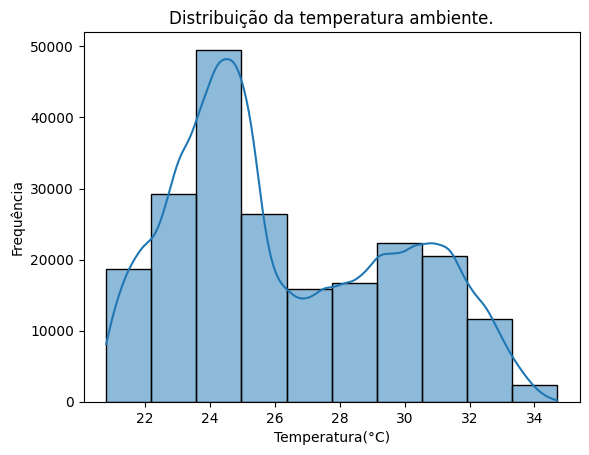

In [19]:
# Distribuição dos dados de TAMB:
sns.histplot(df_limpo['TAMB'], bins=10, kde=True)
plt.title('Distribuição da temperatura ambiente.')
plt.xlabel('Temperatura(°C)')
plt.ylabel('Frequência')
plt.show()

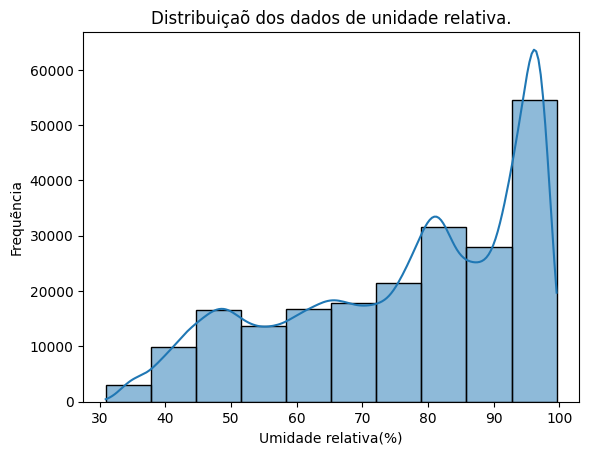

In [20]:
# Distribuição dos dados de RH:
sns.histplot(df_limpo['RH'], kde=True, bins=10)
plt.title('Distribuiçaõ dos dados de unidade relativa.')
plt.xlabel('Umidade relativa(%)')
plt.ylabel('Frequẽncia')
plt.show()

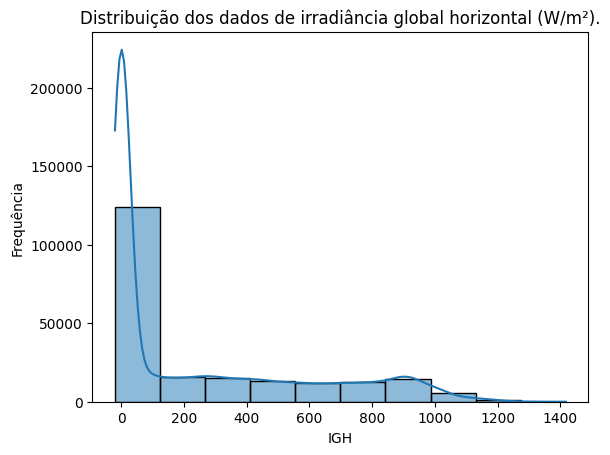

In [21]:
# Distribuição dos de GHI:
sns.histplot(df_limpo['GHI'], kde=True, bins=10)
plt.title('Distribuição dos dados de irradiância global horizontal (W/m²).')
plt.xlabel('IGH')
plt.ylabel('Frequência')
plt.show()

* Dispersão entre as variáveis RH, GHI e TAMB:

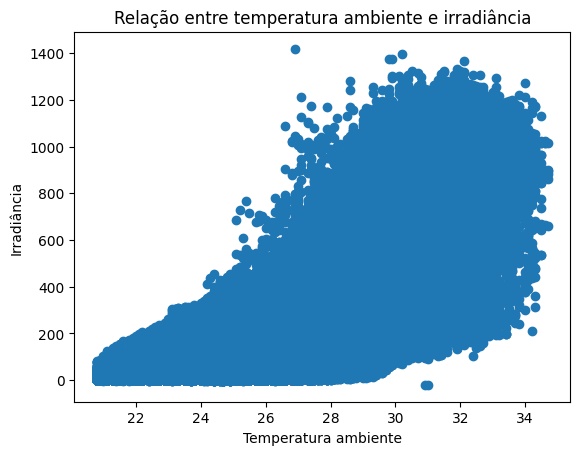

In [22]:
plt.scatter(df_limpo['TAMB'], df_limpo['GHI'])
plt.title('Relação entre temperatura ambiente e irradiância')
plt.xlabel('Temperatura ambiente')
plt.ylabel('Irradiância')
plt.show()

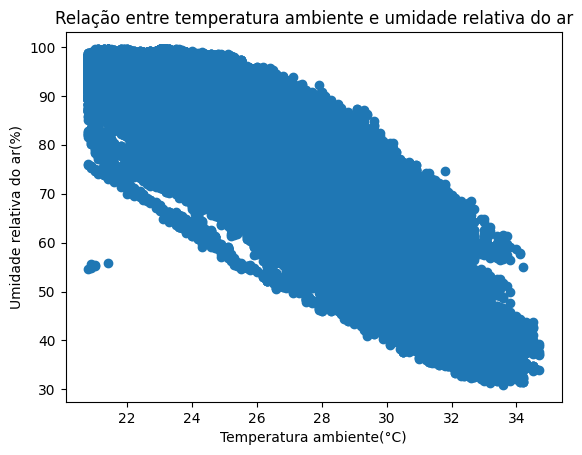

In [23]:
plt.scatter(df_limpo['TAMB'], df_limpo['RH'])
plt.title('Relação entre temperatura ambiente e umidade relativa do ar')
plt.xlabel('Temperatura ambiente(°C)')
plt.ylabel('Umidade relativa do ar(%)')
plt.show()

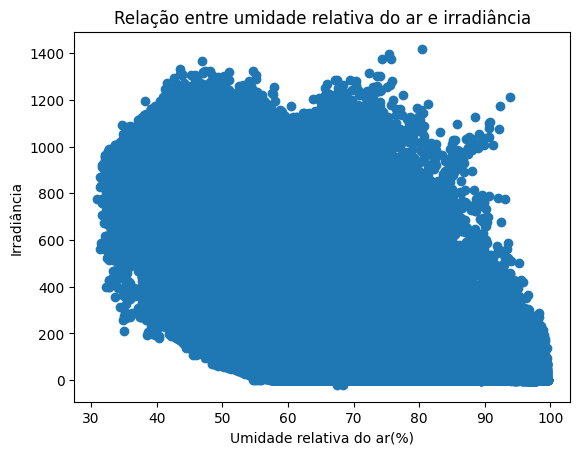

In [24]:
plt.scatter(df_limpo['RH'], df_limpo['GHI'])
plt.title('Relação entre umidade relativa do ar e irradiância')
plt.xlabel('Umidade relativa do ar(%)')
plt.ylabel('Irradiância')
plt.show()

# 1. Vamos analisar a sazonalidade de GHI.

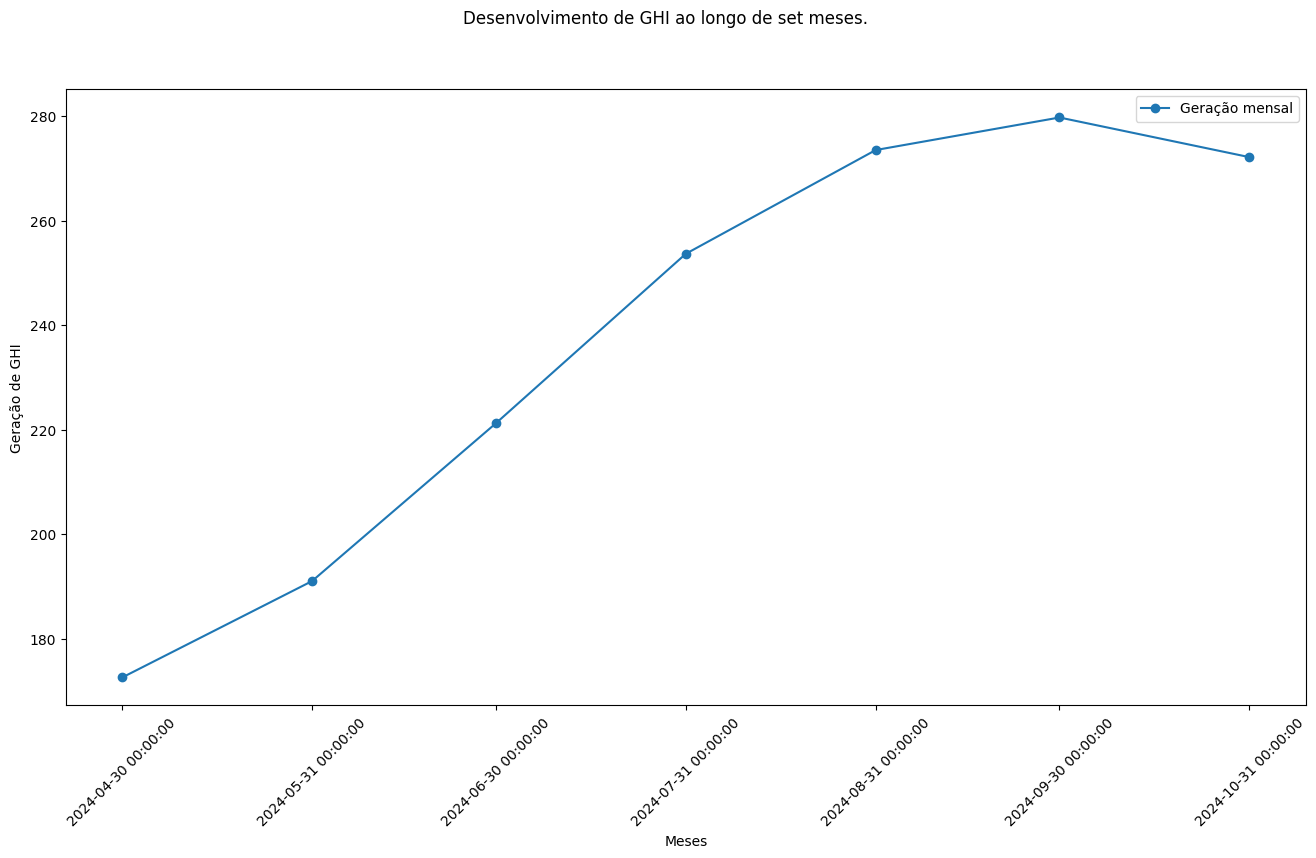

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('Desenvolvimento de GHI ao longo de set meses.')
ax.plot(df_mensal['GHI'], label='Geração mensal', marker='o')
ax.set_xlabel('Meses')
ax.set_ylabel('Geração de GHI')
ax.set_xticks(df_mensal['GHI'].index) 
ax.set_xticklabels(df_mensal['GHI'].index, rotation=45)  
ax.legend()
plt.show()

* Vamos analisar como se comportou a irradiação no mês de abril:

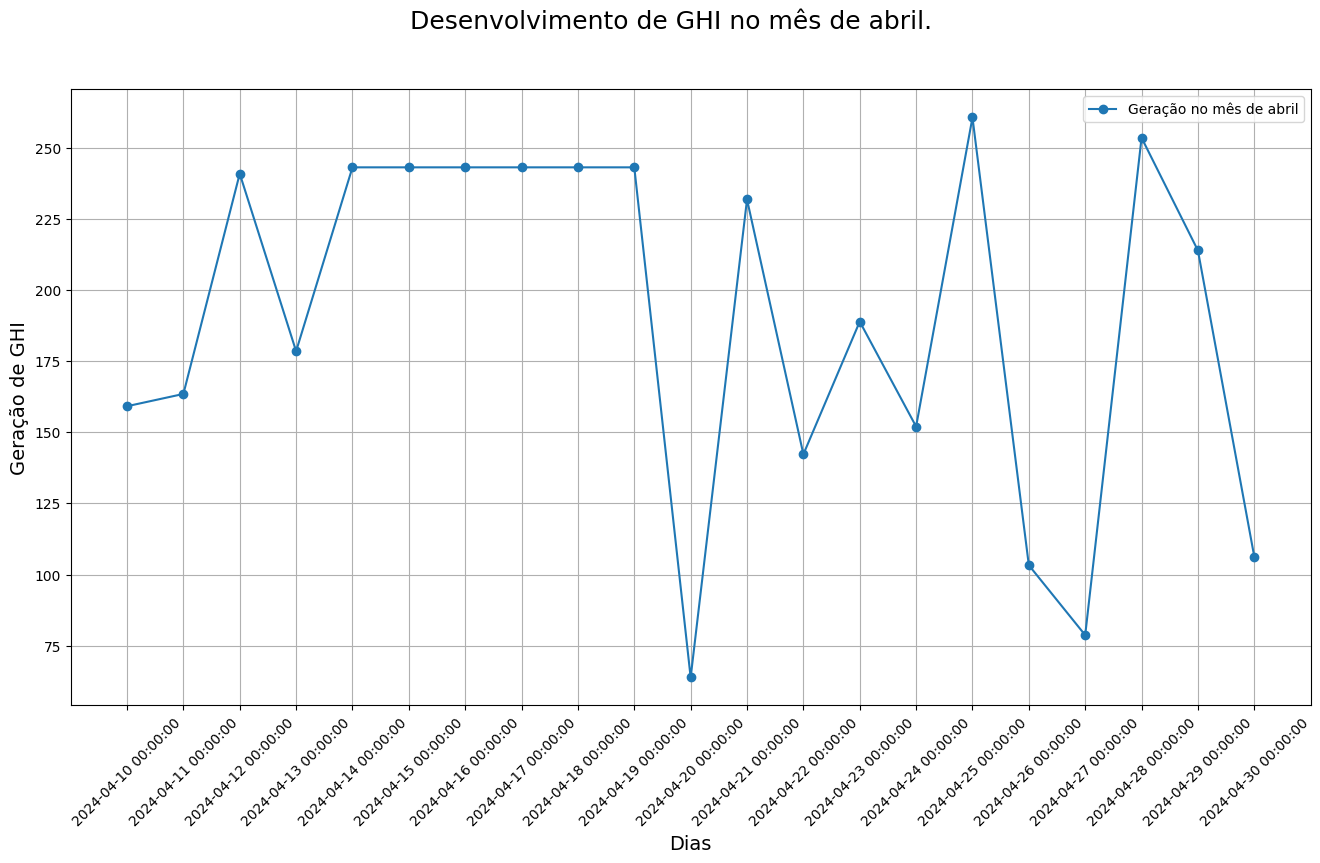

In [30]:
# Primeiro selecionamos somente os registros do mês de abril:
df_abril = df_diario[df_diario.index.month == 4]

# Agora plotamos um graáfico para vê como se comportou o GHI no mês de abril:
fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('Desenvolvimento de GHI no mês de abril.', fontsize=18)
ax.plot(df_abril['GHI'], label='Geração no mês de abril', marker='o')
ax.set_xlabel('Dias', fontsize=14)
ax.set_ylabel('Geração de GHI', fontsize=14)
ax.set_xticks(df_abril['GHI'].index) 
ax.set_xticklabels(df_abril['GHI'].index, rotation=45)  
ax.legend()
plt.grid(True)
plt.show()

* Vamos analisar o  comportamento da irradiação no mês de maio:

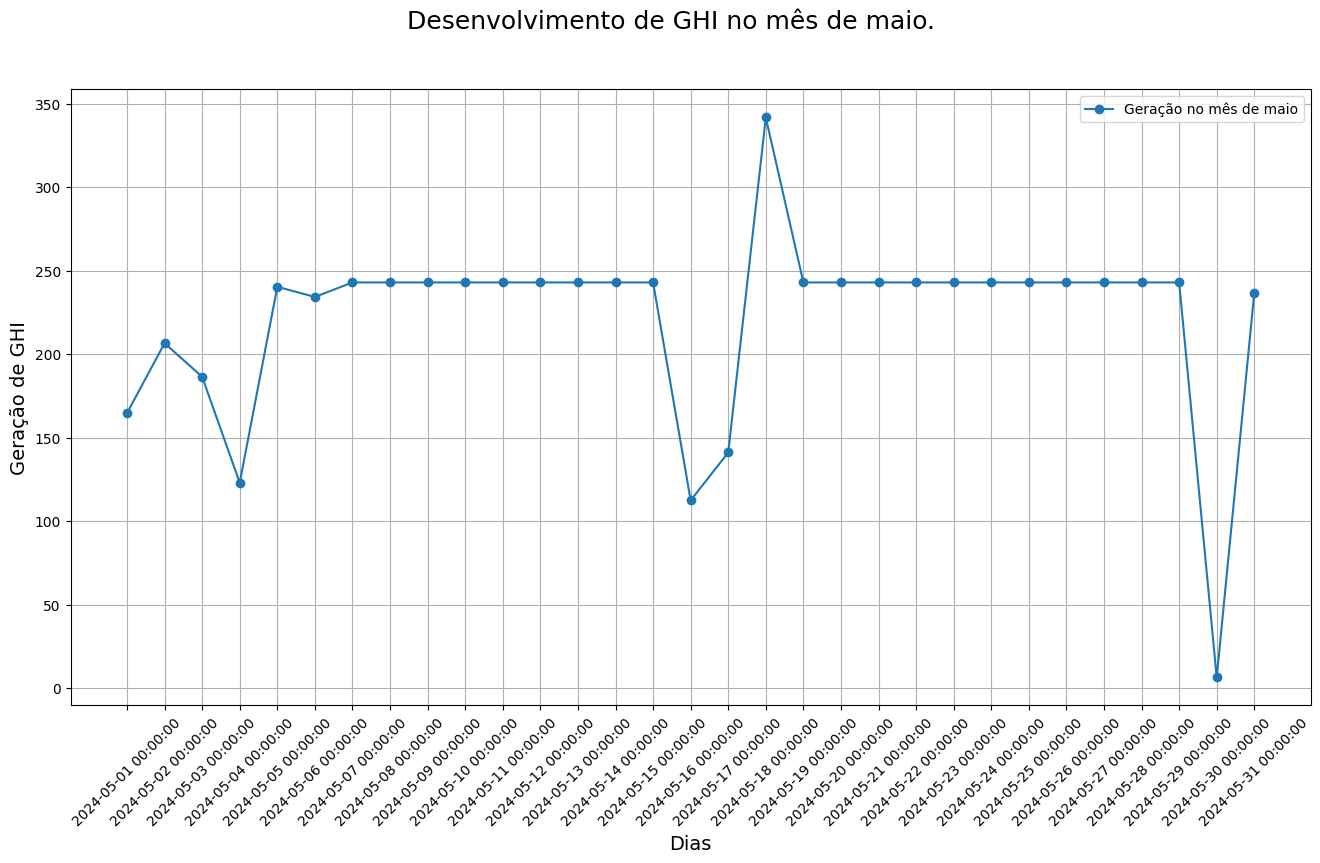

In [29]:
# Primeiro selecionamos somente os registros do mês de maio:
df_maio = df_diario[df_diario.index.month == 5]

# Agora plotamos um graáfico para vê como se comportou o GHI no mês de maio:
fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('Desenvolvimento de GHI no mês de maio.', fontsize=18)
ax.plot(df_maio['GHI'], label='Geração no mês de maio', marker='o')
ax.set_xlabel('Dias', fontsize=14)
ax.set_ylabel('Geração de GHI', fontsize=14)
ax.set_xticks(df_maio['GHI'].index) 
ax.set_xticklabels(df_maio['GHI'].index, rotation=45)  
ax.legend()
plt.grid(True)
plt.show()

* Vamos vê como se comportou o GHI no mês de junho:

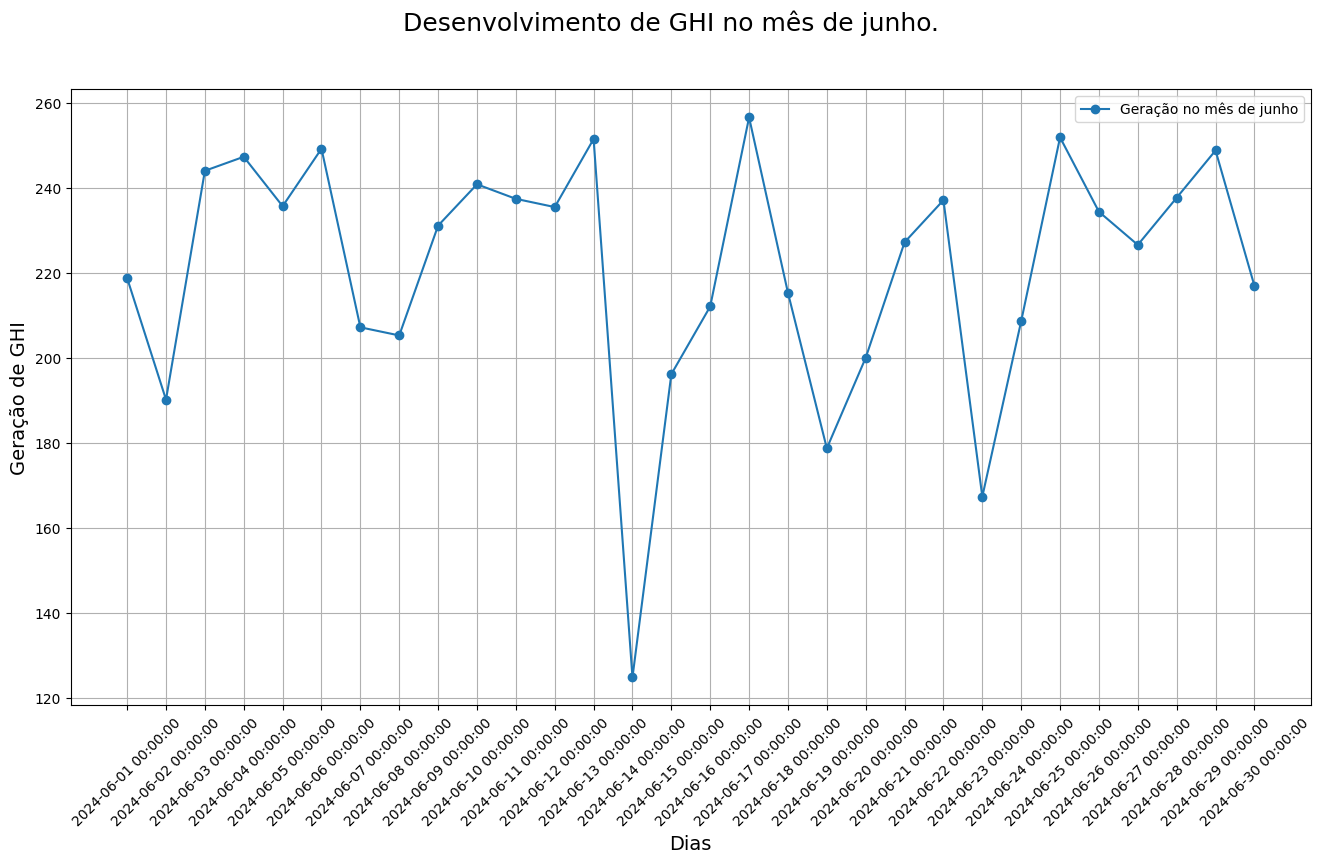

In [28]:
# Primeiro selecionamos somente os registros do mês de junho:
df_junho = df_diario[df_diario.index.month == 6]

# Agora plotamos um gráfico para vê como se comportou o GHI no mês de junho:
fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('Desenvolvimento de GHI no mês de junho.', fontsize=18)
ax.plot(df_junho['GHI'], label='Geração no mês de junho', marker='o')
ax.set_xlabel('Dias', fontsize=14)
ax.set_ylabel('Geração de GHI', fontsize=14)
ax.set_xticks(df_junho['GHI'].index) 
ax.set_xticklabels(df_junho['GHI'].index, rotation=45)  
ax.legend()
plt.grid(True)
plt.show()

* Vamos vê como se comportou o GHI no mês de julho:

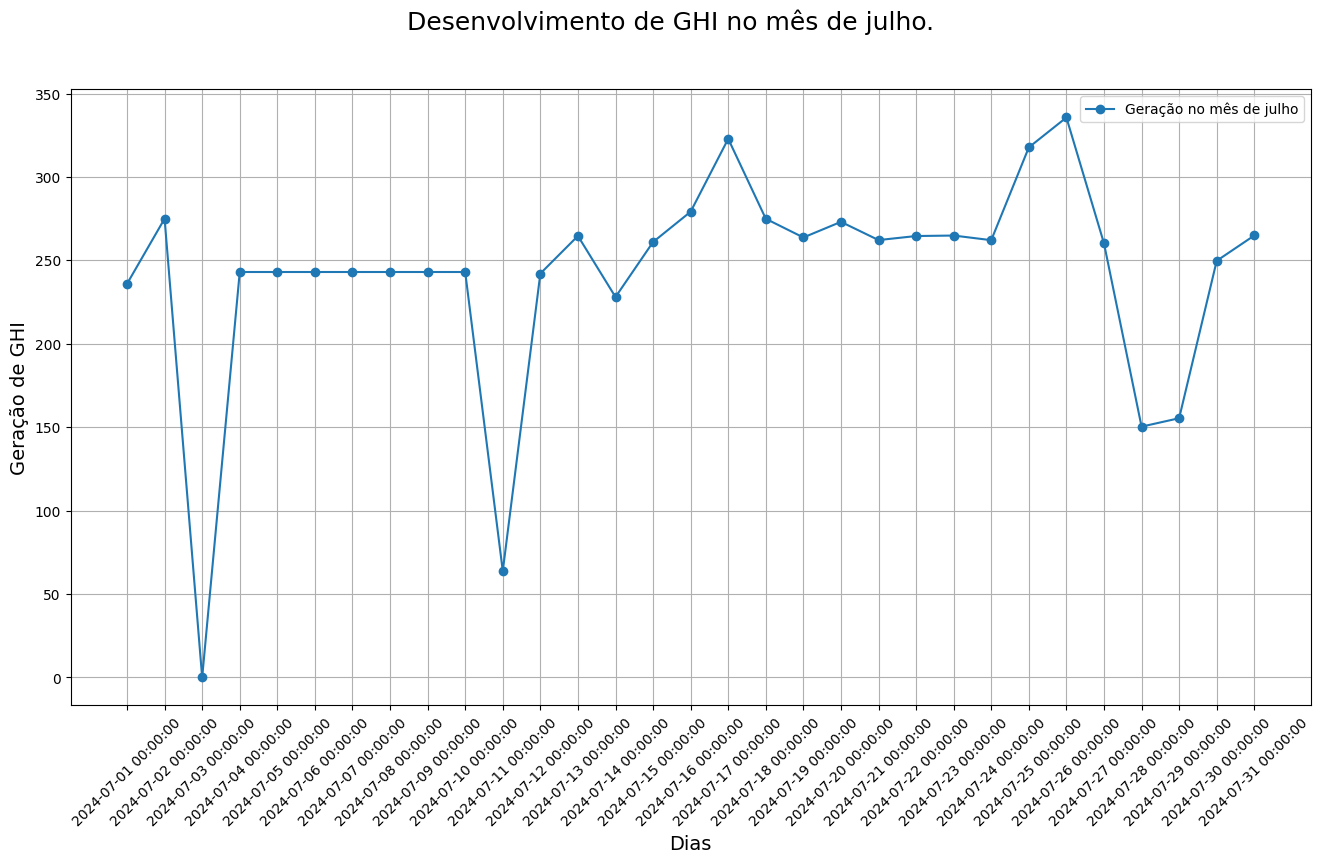

In [31]:
# Primeiro selecionamos somente os registros do mês de julho:
df_julho = df_diario[df_diario.index.month == 7]

# Agora plotamos um graáfico para vê como se comportou o GHI no mês de julho:
fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('Desenvolvimento de GHI no mês de julho.', fontsize=18)
ax.plot(df_julho['GHI'], label='Geração no mês de julho', marker='o')
ax.set_xlabel('Dias', fontsize=14)
ax.set_ylabel('Geração de GHI', fontsize=14)
ax.set_xticks(df_julho['GHI'].index) 
ax.set_xticklabels(df_julho['GHI'].index, rotation=45)  
ax.legend()
plt.grid(True)
plt.show()

* Comportamento do GHI no mês de agosto:

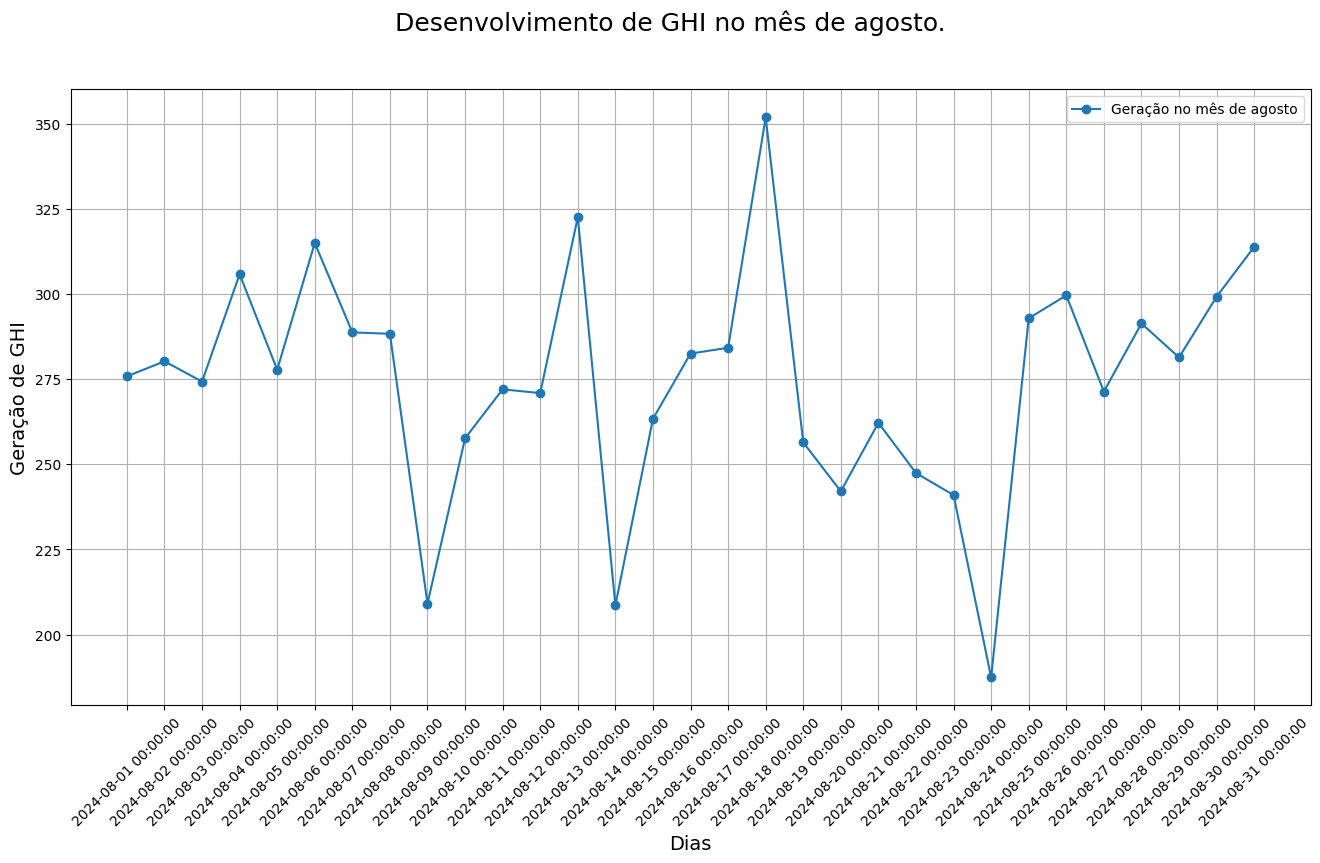

In [32]:
# Primeiro selecionamos somente os registros do mês de agosto:
df_agosto = df_diario[df_diario.index.month == 8]

# Agora plotamos um graáfico para vê como se comportou o GHI no mês de agosto:
fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('Desenvolvimento de GHI no mês de agosto.', fontsize=18)
ax.plot(df_agosto['GHI'], label='Geração no mês de agosto', marker='o')
ax.set_xlabel('Dias', fontsize=14)
ax.set_ylabel('Geração de GHI', fontsize=14)
ax.set_xticks(df_agosto['GHI'].index) 
ax.set_xticklabels(df_agosto['GHI'].index, rotation=45)  
ax.legend()
plt.grid(True)
plt.show()

* Agora vamos vê o desenvolvimento do GHI no mês de setembro:

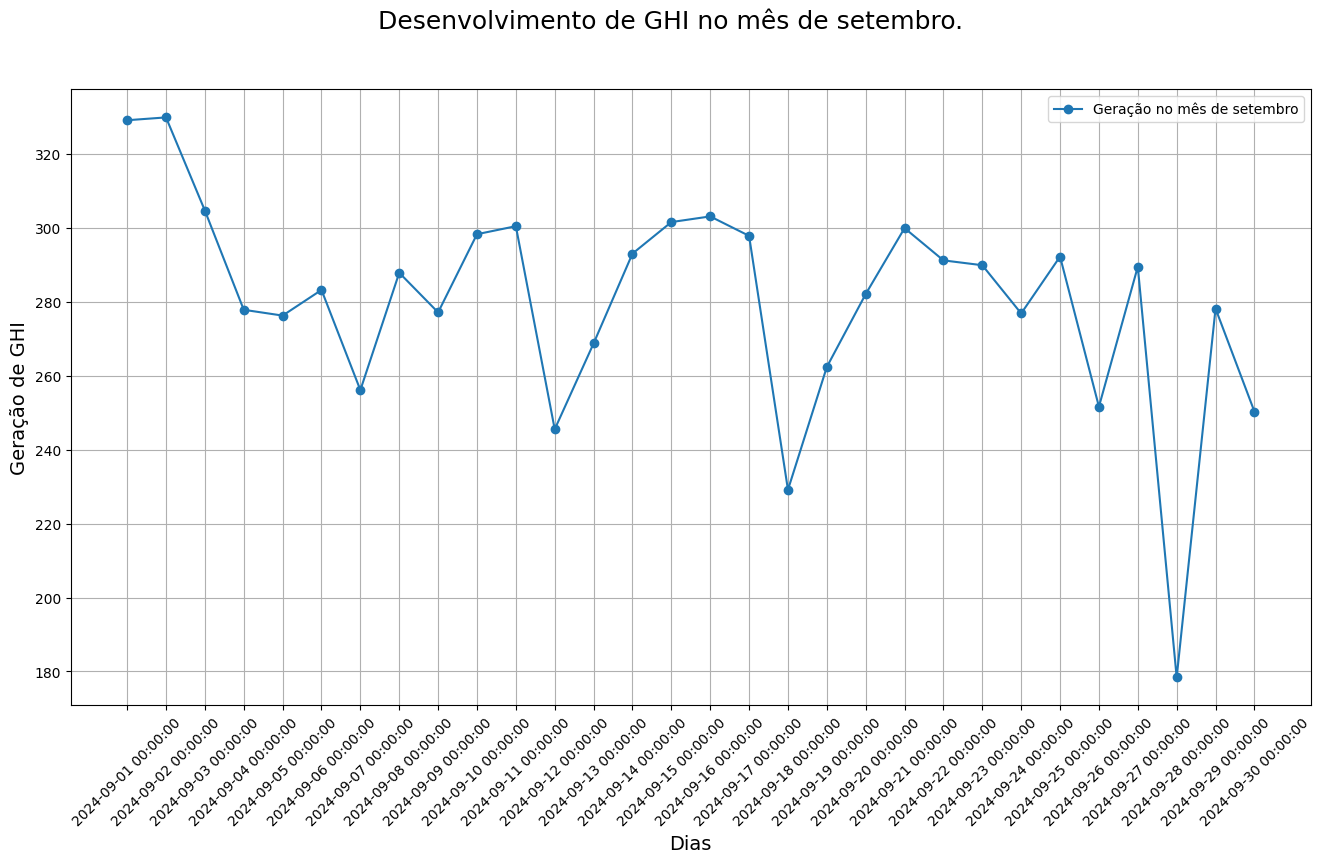

In [34]:
# Primeiro selecionamos somente os registros do mês de setembro:
df_setembro = df_diario[df_diario.index.month == 9]

# Agora plotamos um graáfico para vê como se comportou o GHI no mês de setembro:
fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('Desenvolvimento de GHI no mês de setembro.', fontsize=18)
ax.plot(df_setembro['GHI'], label='Geração no mês de setembro', marker='o')
ax.set_xlabel('Dias', fontsize=14)
ax.set_ylabel('Geração de GHI', fontsize=14)
ax.set_xticks(df_setembro['GHI'].index) 
ax.set_xticklabels(df_setembro['GHI'].index, rotation=45)  
ax.legend()
plt.grid(True)
plt.show()

* Desenvolvimento de GHI no mês de outubro:

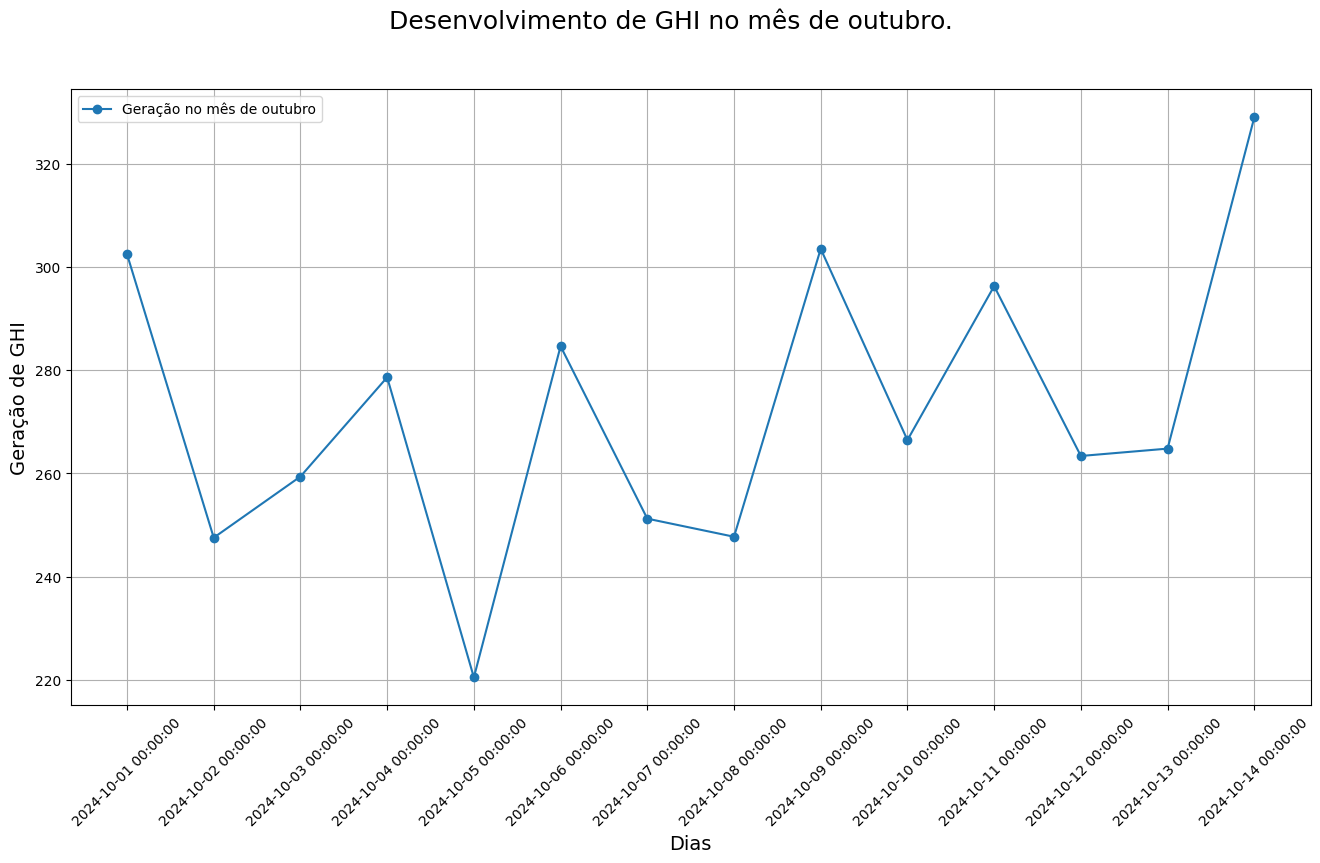

In [35]:
# Primeiro selecionamos somente os registros do mês de outubro:
df_outubro = df_diario[df_diario.index.month == 10]

# Agora plotamos um graáfico para vê como se comportou o GHI no mês de outubro:
fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('Desenvolvimento de GHI no mês de outubro.', fontsize=18)
ax.plot(df_outubro['GHI'], label='Geração no mês de outubro', marker='o')
ax.set_xlabel('Dias', fontsize=14)
ax.set_ylabel('Geração de GHI', fontsize=14)
ax.set_xticks(df_outubro['GHI'].index) 
ax.set_xticklabels(df_outubro['GHI'].index, rotation=45)  
ax.legend()
plt.grid(True)
plt.show()